# Weight and bias initialisers

In this reading we investigate different ways to initialise weights and biases in the layers of neural networks.

In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
print(tf.__version__)

2025-11-25 23:36:38.738496: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 23:36:39.429855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 23:36:41.914106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


### Default weights and biases

In the models we have worked with so far, we have not specified the initial values of the weights and biases in each layer of our neural networks.

The default values of the weights and biases in TensorFlow depend on the type of layers we are using.

For example, in a `Dense` layer, the biases are set to zero (`zeros`) by default, while the weights are set according to `glorot_uniform`, the Glorot uniform initialiser.

The Glorot uniform initialiser draws the weights uniformly at random from the closed interval $[-c,c]$, where $$c = \sqrt{\frac{6}{n_{input}+n_{output}}}$$

and $n_{input}$ and $n_{output}$ are the number of inputs to, and outputs from the layer respectively.

### Initialising your own weights and biases
We often would like to initialise our own weights and biases, and TensorFlow makes this process quite straightforward.

When we construct a model in TensorFlow, each layer has optional arguments `kernel_initialiser` and `bias_initialiser`, which are used to set the weights and biases respectively.

If a layer has no weights or biases (e.g. it is a max pooling layer), then trying to set either `kernel_initialiser` or `bias_initialiser` will throw an error.

Let's see an example, which uses some of the different initialisations available in Keras.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D

In [3]:
#Constructing a model

model = Sequential([
    Conv1D(filters=16, kernel_size=3, input_shape=(128, 64), kernel_initializer='random_uniform', bias_initializer="zeros", activation='relu'),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(64, kernel_initializer='he_uniform', bias_initializer='ones', activation='relu'),
])

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764135406.502435    1750 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


As the following example illustrates, we can also instantiate initialisers in a slightly different manner, allowing us to set optional arguments of the initialisation method.

In [4]:
#Adding some layers to our model

model.add(Dense(64,
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
                bias_initializer=tf.keras.initializers.Constant(value=0.4),
                activation='relu'),)

model.add(Dense(8,
                kernel_initializer=tf.keras.initializers.Orthogonal(gain=1.0, seed=None),
                bias_initializer=tf.keras.initializers.Constant(value=0.4),
                activation='relu'))

### Custom weight and bias initialisers
It is also possible to define your own weight and bias initialisers.
Initializers must take in two arguments, the `shape` of the tensor to be initialised, and its `dtype`.

Here is a small example, which also shows how you can use your custom initializer in a layer.

In [5]:
import tensorflow.keras.backend as K

In [6]:
#Example of a custom initializer

def my_init(shape, dtype=None):
    return K.random_normal(shape, dtype=dtype)

model.add(Dense(64, kernel_initializer=my_init))

Let's take a look at the summary of our finalised model.

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 16)        │         3,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 31, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        31,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,152 (156.84 KB)

 Trainable params: 40,152 (156.84 KB)

 Non-trainable params: 0 (0.00 B)

### Visualising the initialised weights and biases

Finally, we can see the effect of our initialisers on the weights and biases by plotting histograms of the resulting values. Compare these plots with the selected initialisers for each layer above.

In [8]:
import matplotlib.pyplot as plt

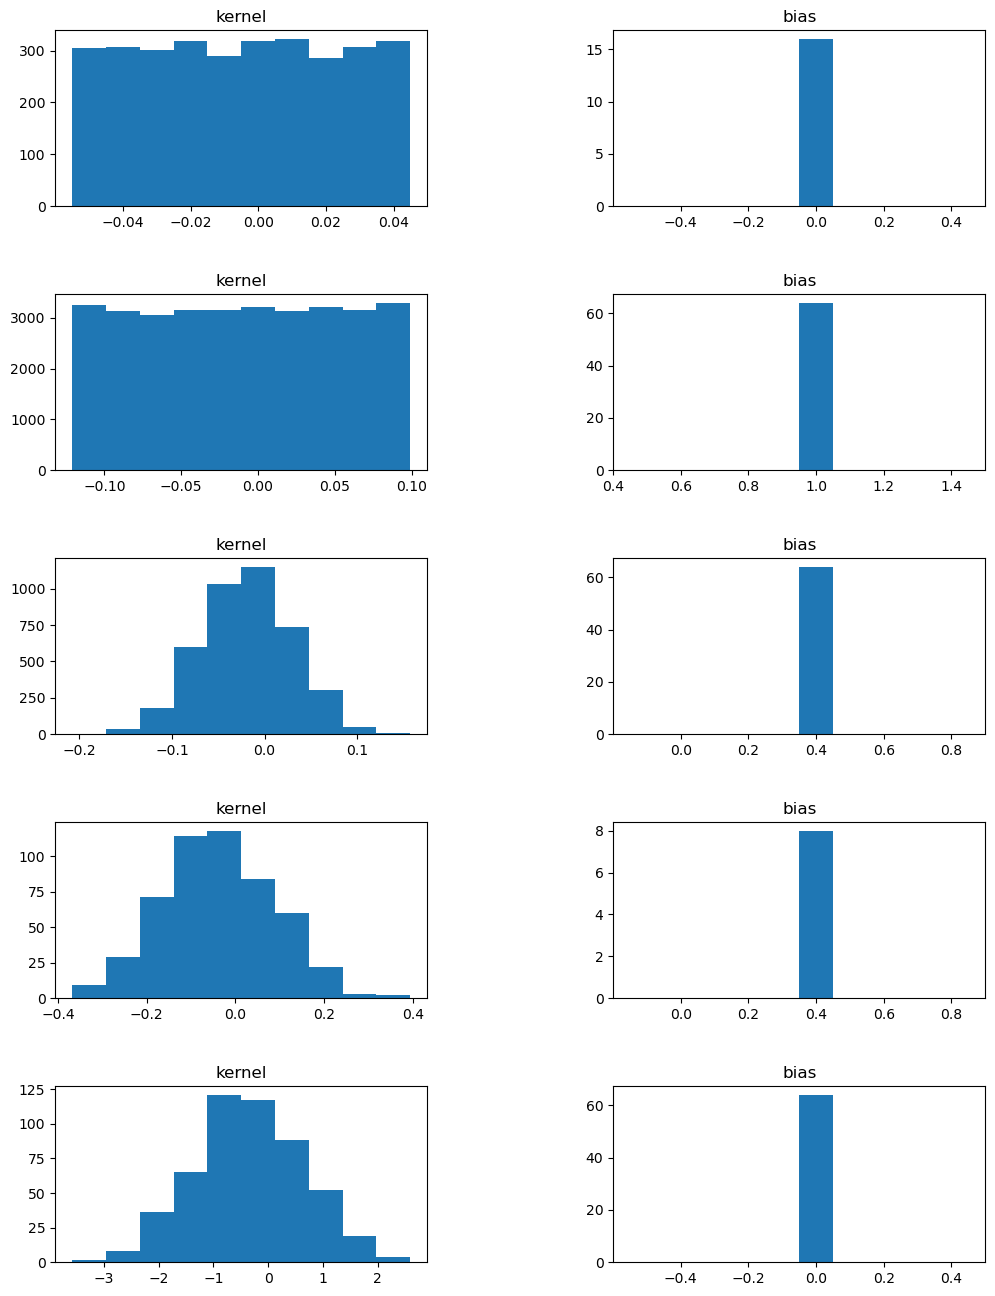

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(12,16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Filter out the pooling and flatten layers, that don't have any weights
weight_layers = [layer for layer in model.layers if len(layer.weights) > 0]

for i, layer in enumerate(weight_layers):
    for j in [0, 1]:
        axes[i, j].hist(layer.weights[j].numpy().flatten(), align='left')
        axes[i, j].set_title(layer.weights[j].name)

## Further reading and resources
* https://keras.io/initializers/
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers